# Naïve Bayes



Hello everyone! In this Notebook we will learn about the Naïve Bayes method. With sklearn, Naïve Bayes is nice and easy. But (channeling Tina Turner) there is just one thing. Somehow I never ever seem to do nothing nice and easy. So I would like to do Naïve Bayes nice and rough.  If you want it nice and easy skip to the end.



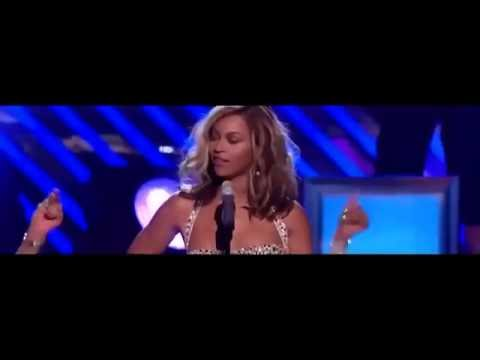

In [146]:
from IPython.display import YouTubeVideo
from datetime import timedelta

start=int(timedelta(hours=1, minutes=46, seconds=40).total_seconds())

#https://youtu.be/dIv-7mXcf1k?t=1m33s
YouTubeVideo("W_y1NzA4jEc", start=96)

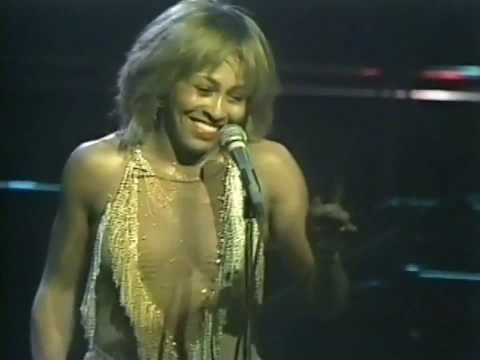

In [2]:
YouTubeVideo("EqIpkMDRjYw")

## Nice and Rough
By the rough version I mean writing the algorithm from scratch. Also by *rough* I mean that I am sure there is a better way to do this in Pandas if I was more fluent in it. If you find a better way let me know. You may get rough karma xp.

Anyway, this rough version isn't too hard (arghh, I hate it when I say that - let's just say it's not nice and easy and it is not nice and hard). First I will use the quad copter data:

In [10]:
import pandas as pd
quad = pd.read_csv('https://raw.githubusercontent.com/zacharski/machine-learning/master/data/quad.csv')
quad['Fly Quad?'] = quad['Fly Quad?'].astype('category')
quad = quad.set_index('Day')
quad

,Outlook,Temperature,Humidity,Wind,Fly Quad?
Day,,,,,
1,Sunny,Hot,High,Weak,No
2,Sunny,Hot,High,Strong,No
3,Overcast,Hot,High,Weak,Yes
4,Rain,Mild,High,Weak,Yes
5,Rain,Cool,Normal,Weak,Yes
6,Rain,Cool,Normal,Strong,No
7,Overcast,Cool,Normal,Strong,Yes
8,Sunny,Mild,High,Weak,No
9,Sunny,Cool,Normal,Weak,Yes


So we want to learn how to predict the values in the last column, *Fly Quad?*. Just for sake of English discussion let's give that column we want to predict, a name, `classColumn`

Here is what we want the algorithm to do

    for each category in the classColumn (No and Yes in this case)
        for each of the other columns:
           compute the conditional probabilities of the value in the other column given the value in the classColumn
           

So compute things like:

## $$P(rain|no) $$

which means the probability that it is raining given that I didn't fly my quad.
## $$P(sunny|no) $$

(the probability that it is sunny given that I didn't fly my quad)

and so on. 

So if we did this mostly by hand....

Let's look at the table when we say yes to fly:

In [11]:
fly = quad.loc[quad['Fly Quad?'] == 'Yes']

fly

,Outlook,Temperature,Humidity,Wind,Fly Quad?
Day,,,,,
3,Overcast,Hot,High,Weak,Yes
4,Rain,Mild,High,Weak,Yes
5,Rain,Cool,Normal,Weak,Yes
7,Overcast,Cool,Normal,Strong,Yes
9,Sunny,Cool,Normal,Weak,Yes
10,Rain,Mild,Normal,Weak,Yes
11,Sunny,Mild,Normal,Strong,Yes
12,Overcast,Mild,High,Strong,Yes
13,Overcast,Hot,Normal,Weak,Yes


Cool.  Now, for the moment we will focus our attention on values in the outlook column:

In [12]:
grouped = fly['Outlook'].groupby(fly['Outlook'])
grouped

Now, we will count how many times it was sunny, how many times it was overcast, etc.

In [10]:
grouped.count()

Outlook
Overcast    4
Rain        3
Sunny       2
Name: Outlook, dtype: int64

and let's just sum those up so we get the total

In [15]:
grouped.count().sum()



9

ok, looking at the last 2 calculations,  4 of the 9 days that we fly the drone were overcast, 3 were rainy and 2 were sunny.  So we get those probabilities

### $$P(overcast|yes) = 4/9 = .444$$
### $$P(rain|yes) = 3/9 = .333$$
### $$P(sunny|yes) = 2/9 = .222$$

Now I am going to write a function `computeTrainingProb` that computes these probabilities

In [124]:
def constructProbabilities(df, columnValues):
    """this computes the probabilities for one class-- for example,
       when fly=Yes
       It returns a dictionary"""
    classProbabilities = {}
    for column in df:        
        grouped = df[column].groupby(df[column])
        gc = grouped.count()
        columnProb ={}
        total = gc.sum()
        for category in columnValues[column]:
            if category in gc.index.values:
                columnProb[category] = gc.loc[category] / total
            else:
                columnProb[category] = 0
        classProbabilities[column] = columnProb
    return classProbabilities
        
def computeTrainingProb(training_df, classColumn):
     # first get a priori probabilities
     
     grouped = training_df[classColumn].groupby(training_df[classColumn])
     gc = grouped.count()   
     apriori = {}
     total = gc.sum()   
     for category, count in gc.iteritems():
        apriori[category] = count / total
        
     # Now let's get the unique values for each column. 
     # Let's stash them in a dictionary
     columnValues = {}
     for column in training_df:
            columnValues[column] = training_df[column].unique()
     
     # now compute the conditioanal probabilities   
     predictionvalues = training_df[classColumn].unique()
     probabilities= {}
    
     for x in predictionvalues:
        tmp = constructProbabilities(training_df.loc[training_df[classColumn] == x], columnValues)
        probabilities[x] = tmp
     return (apriori, probabilities)

aprioriPr, conditionalPr = computeTrainingProb(quad, 'Fly Quad?')
print(aprioriPr)
print(conditionalPr)


{0: 0.35714285714285715, 1: 0.6428571428571429}
{0: {'Day': {1: 0.20000000000000001, 2: 0.20000000000000001, 3: 0, 4: 0, 5: 0, 6: 0.20000000000000001, 7: 0, 8: 0.20000000000000001, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0.20000000000000001}, 'Outlook': {2: 0.59999999999999998, 0: 0, 1: 0.40000000000000002}, 'Temperature': {1: 0.40000000000000002, 2: 0.40000000000000002, 0: 0.20000000000000001}, 'Humidity': {0: 0.80000000000000004, 1: 0.20000000000000001}, 'Wind': {1: 0.40000000000000002, 0: 0.59999999999999998}, 'Fly Quad?': {0: 1.0, 1: 0}}, 1: {'Day': {1: 0, 2: 0, 3: 0.1111111111111111, 4: 0.1111111111111111, 5: 0.1111111111111111, 6: 0, 7: 0.1111111111111111, 8: 0, 9: 0.1111111111111111, 10: 0.1111111111111111, 11: 0.1111111111111111, 12: 0.1111111111111111, 13: 0.1111111111111111, 14: 0}, 'Outlook': {2: 0.22222222222222221, 0: 0.44444444444444442, 1: 0.33333333333333331}, 'Temperature': {1: 0.22222222222222221, 2: 0.44444444444444442, 0: 0.33333333333333331}, 'Humidity': {0: 0.333333

So in our scheme:

### $$P(wind:strong|fly) $$ is

In [91]:
conditionalPr['Yes']['Wind']['Strong']

0.33333333333333331

and the probability that given we don't fly it is overcast:

In [92]:
conditionalPr['No']['Outlook']['Overcast']

0

### Probabilities of zero
Probabilities of zero are problematic for Naive Bayes Classification.

Starting on page 6-36 of the book, it explains why it is a problem.  The book offers one solution. (You should read chapter 6 before starting this Notebook) Let's implement a slightly easier one:

### $$P(x | y) = \frac{m_c + 1}{n + m}$$

So in the overcast case when we don't fly. $m_c$ is 0, n = 5, and m is 3 (for sunny, overcast, rain) so we should get

### $$P(x | y) = \frac{m_c + 1}{n + m} = \frac{0 + 1}{5 + 3}  = \frac{1}{8} = 0.125 $$

<h1 style="color:red">Task 1: Modify the code to implement this change: 25xp</h1>

In [117]:
## modify this code

def constructProbabilities(df, columnValues):
    """this computes the probabilities for one class-- for example,
       when fly=Yes
       It returns a dictionary"""
    classProbabilities = {}
    for column in df:        
        grouped = df[column].groupby(df[column])
        gc = grouped.count()
        columnProb ={}
        total = gc.sum()
        for category in columnValues[column]:
            if category in gc.index.values:
                columnProb[category] = gc.loc[category] / total
            else:
                columnProb[category] = 0
        classProbabilities[column] = columnProb
    return classProbabilities
        
def computeTrainingProb(training_df, classColumn):
     # first get a priori probabilities
     
     grouped = training_df[classColumn].groupby(training_df[classColumn])
     gc = grouped.count()   
     apriori = {}
     total = gc.sum()   
     for category, count in gc.iteritems():
        apriori[category] = count / total
        
     # Now let's get the unique values for each column. 
     # Let's stash them in a dictionary
     columnValues = {}
     for column in training_df:
            columnValues[column] = training_df[column].unique()
     
     # now compute the conditioanal probabilities   
     predictionvalues = training_df[classColumn].unique()
     probabilities= {}
    
     for x in predictionvalues:
        tmp = constructProbabilities(training_df.loc[training_df[classColumn] == x], columnValues)
        probabilities[x] = tmp
     return (apriori, probabilities)

aprioriPr, conditionalPr = computeTrainingProb(quad, 'Fly Quad?')
#print(aprioriPr)
#print(conditionalPr)  

for k, v in conditionalPr['No'].items():
    print (k, v)

print('\n\nYES')
for k, v in conditionalPr['Yes'].items():
    print (k, v)


Outlook {'Sunny': 0.5, 'Overcast': 0.125, 'Rain': 0.375}
Temperature {'Hot': 0.375, 'Mild': 0.375, 'Cool': 0.25}
Humidity {'High': 0.7142857142857143, 'Normal': 0.2857142857142857}
Wind {'Weak': 0.42857142857142855, 'Strong': 0.5714285714285714}
Fly Quad? {'No': 0.8571428571428571, 'Yes': 0.14285714285714285}


YES
Outlook {'Sunny': 0.25, 'Overcast': 0.41666666666666669, 'Rain': 0.33333333333333331}
Temperature {'Hot': 0.25, 'Mild': 0.41666666666666669, 'Cool': 0.33333333333333331}
Humidity {'High': 0.36363636363636365, 'Normal': 0.63636363636363635}
Wind {'Weak': 0.63636363636363635, 'Strong': 0.36363636363636365}
Fly Quad? {'No': 0.090909090909090912, 'Yes': 0.90909090909090906}


 here is the test:

In [98]:
conditionalPr['No']['Outlook']['Overcast']


0.125

Check to see if your code produces results that are the same as:

##### YES to Fly Quad
column | Category | value | Category | value | Category | value
 :---: | :---: | ---: | :---: | ---: | :---: | ---: 
 Outlook | Sunny | 0.25  | Overcast |  0.4166 | Rain | 0.333
 Temperature | Hot |  0.25 | Mild | 0.4166 | Cool | 0.33333
 Humidity | High | 0.3636 | Normal | 0.6363
Wind | Weak |  0.63636 | Strong | 0.363636 


<h1 style="color:red">Task 2: Write the code to make a prediction from a row of values: 25xp</h1>

Let's work through an example. Suppose

* Outlook Sunny
* Temperature Hot
* Humidity High
* Wind Strong

Let's create a table and populate it with our probabilities

Fly? | apriori prob | P(Sunny&#124;fly?) |P(Hot&#124;fly?) |P(High&#124;fly?) |P(Strong&#124;fly?) | Total | Normalized
:---: | ---: | ---: | ---: | ---: | ---: | ---: | ---:
Yes  | 0.6428 | .25 |  0.25 | 0.3636 | 0.3636 | 0.005312 | 0.1627456
No | 0.3571 | 0.5 | 0.375 | 0.7142 | 0.5714 |   0.027332 | 0.8372543


The total column is the row values multiplied together so
 
$$ 0.6428 \times 0.25 \times  0.25 \times 0.3636 \times 0.3636 = 0.005312 $$

The normalized column makes it so that the 'no' and 'yes' probabilities add up to one.

One little Python reminder. To sort a list of tuples by the second element you do:


In [125]:
grades = [('Ann', 87), ('Bill', 86, ), ('Clara', 97), ('Danny', 92)]
sorted(grades, key=lambda x: x[1], reverse=True )

[('Clara', 97), ('Danny', 92), ('Ann', 87), ('Bill', 86)]

### alright - do the work:

In [17]:
def predict(df, apriori, conditional):
    """the function takes 3 arguments:
          df: the row of data we want to make a prediction on
          apriori: the Python dictionary of a priori probabilities
          conditional: the Python dictionary of conditional Probabilities
          
          It should return a sorted list of tuples showing the most probable
          prediction first. For example:
          
          [('No', 0.83725435925823422), ('Yes', 0.1627456407417659)]
          
          """
         #### YOUR CODE HERE

import pandas as pd
df = pd.DataFrame({'Test1': [1, 2, 3], 'Test2': [10, 20, 30] }, index=['Ann','Ben', 'Clara'])
df.sum(1)
tt = quad.loc[2].drop('Fly Quad?')

predict(tt, aprioriPr, conditionalPr)

[('No', 0.92103600758054327), ('Yes', 0.07896399241945673)]

**Fantastic!**

### Run your prediction code on a test set.

Suppose I have a little test set like 

 Outlook | Temperature | Humidity | Wind | Fly Quad?
  :----: | :----: | :----: | :----: | :----: | 
 Rain |	Cool	| High	| Weak | 	No
 	Sunny |	Cool	| High | 	Strong |	No
 	Overcast |	Hot | 	High |	Strong |	Yes
 	Overcast	 | Mild	| Normal	| Weak | 	Yes
 	Rain	| Mild	| Normal |	Weak |	Yes

First, let's make a DataFrame

In [25]:
quad_test = pd.DataFrame({'Outlook': ['Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
                          'Temperature': ['Cool', 'Cool', 'Hot', 'Mild', 'Mild'],
                          'Humidity': ['High', 'High', 'High', 'Normal', 'Normal'],
                          'Wind': ['Weak', 'Strong', 'Strong', 'Weak', 'Weak'],
                          'Fly Quad?': ['No', 'No', 'Yes', 'Yes', 'Yes']})
quad_test

,Fly Quad?,Humidity,Outlook,Temperature,Wind
0,No,High,Rain,Cool,Weak
1,No,High,Sunny,Cool,Strong
2,Yes,High,Overcast,Hot,Strong
3,Yes,Normal,Overcast,Mild,Weak
4,Yes,Normal,Rain,Mild,Weak


now the code to run this test data through our prediction algorithm

In [21]:

predictor = lambda x:  predict(x, aprioriPr, conditionalPr)[0][0]

In [24]:

predictions = quad_test[['Outlook', 'Temperature', 'Humidity', 'Wind']].apply(predictor, axis=1)
predictions

0    Yes
1     No
2    Yes
3    Yes
4    Yes
dtype: object

We can just eyeball the accuracy, but let's go ahead and calculate it.

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(quad_test['Fly Quad?'], predictions)


0.80000000000000004

<h1 style="color:red">Task 3: Predicting Republican or Democrat: 25xp</h1>
<img src="http://3.bp.blogspot.com/-JCFOE9moLMY/USJq5xLj0FI/AAAAAAAAAUg/abkl8SA5SwQ/s1600/Dividist+Logo.png" width="350" />
Using the  [
Congressional Voting Records Data Set ](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records) can you use the above algorithm to decide whether someone is a Democrat or Republican?

For this exercise you can remove the rows that have missing values.

You should split your data so you train on 80% and test on 20%

#### what is your accuracy?

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(vote_test['party'], predictions)

0.95744680851063835

# Nice and Easy - using sklearn
<img src="http://www.rippingballs.com/wp-content/uploads/2015/08/IMG_1393.jpg" width="400" />

Ok, so here is what you have been waiting for. The nice and easy approach using sklearn. First, let's do some grungy data wrangling.

In [62]:
import pandas as pd
quad = pd.read_csv('https://raw.githubusercontent.com/zacharski/machine-learning/master/data/quad.csv')

quad['Outlook'] = quad['Outlook'].astype('category')
quad['Temperature'] = quad['Temperature'].astype('category')
quad['Humidity'] = quad['Humidity'].astype('category')
quad['Wind'] = quad['Wind'].astype('category')
quad['Fly Quad?'] = quad['Fly Quad?'].astype('category')

cat_columns = quad.select_dtypes(['category']).columns
quad[cat_columns] = quad[cat_columns].apply(lambda x: x.cat.codes)

# now I will create my small test set as I did above:

quad_test = pd.DataFrame({'Outlook': ['Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
                          'Temperature': ['Cool', 'Cool', 'Hot', 'Mild', 'Mild'],
                          'Humidity': ['High', 'High', 'High', 'Normal', 'Normal'],
                          'Wind': ['Weak', 'Strong', 'Strong', 'Weak', 'Weak'],
                          'Fly Quad?': ['No', 'No', 'Yes', 'Yes', 'Yes']})
quad_test['Outlook'] = quad_test['Outlook'].astype('category')
quad_test['Temperature'] = quad_test['Temperature'].astype('category')
quad_test['Humidity'] = quad_test['Humidity'].astype('category')
quad_test['Wind'] = quad_test['Wind'].astype('category')
quad_test['Fly Quad?'] = quad_test['Fly Quad?'].astype('category')
cat_columns = quad_test.select_dtypes(['category']).columns
quad_test[cat_columns] = quad_test[cat_columns].apply(lambda x: x.cat.codes)
quad_test

,Fly Quad?,Humidity,Outlook,Temperature,Wind
0,0,0,1,0,1
1,0,0,2,0,0
2,1,0,0,1,0
3,1,1,0,2,1
4,1,1,1,2,1


All the above looked like a lot of work (and it was) but it was just converting the categorical attributes in the quad dataset to numeric ones. That was something like 90% of the work!

# Training the Naive Bayes Classifier

Ok so here....

Finally ...

Is the super easy Naive Bayes Classifier:

In [61]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(quad[['Outlook', 'Temperature', 'Humidity', 'Wind']], quad['Fly Quad?'])

GaussianNB(priors=None)

### Using the Naive Bayes Classifier to make Predictions

In [63]:
predictions = clf.predict(quad_test[['Outlook', 'Temperature', 'Humidity', 'Wind']])
predictions

array([1, 0, 1, 1, 1], dtype=int8)

## Gaussian Bayes Classifier
The Naïve Bayes classifier was originally designed to work with categorical data. 
Starting on page 6.45 of the book, I describe a variation of the algorithm that can be applied to numerical data. The sklearn algorithm we just used is a Gaussian one which can easily handle numeric data. Let's give it a try
<img src="https://upload.wikimedia.org/wikipedia/commons/1/1e/IMG_7911-Iris_virginica.jpg" width="250" />


In [120]:
from sklearn.model_selection import train_test_split

iris = pd.read_csv('https://raw.githubusercontent.com/zacharski/machine-learning/master/data/iris.csv')
iris_train, iris_test = train_test_split(iris, test_size = 0.2)

irisClf = GaussianNB()
irisClf.fit(iris_train[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']], iris_train['Class'])

GaussianNB(priors=None)

In [121]:
iris_predictions = irisClf.predict(iris_test[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']])
from sklearn.metrics import accuracy_score
accuracy_score(iris_test['Class'], iris_predictions)

0.96666666666666667

So we loaded the data, build and trained a classifier, and used it to make predictions. all in 8 lines of code!!!




<h1 style="color:red">Task 4: Using sklearn to predict Republican or Democrat: 35xp</h1>
        
The header explains it all. Please show the accuracy        
<img src="https://goodmorningwilton.com/wp-content/uploads/2016/01/republican-elephant-and-democratic-donkey-icons-party-symbols.jpg" width="350" />


GaussianNB(priors=None)

In [118]:
from sklearn.metrics import accuracy_score
accuracy_score(vote_test['party'], predictions)

0.8936170212765957

### I am happy to report that the classifier I built using the **nice and rough** method outperformed the sklearn one

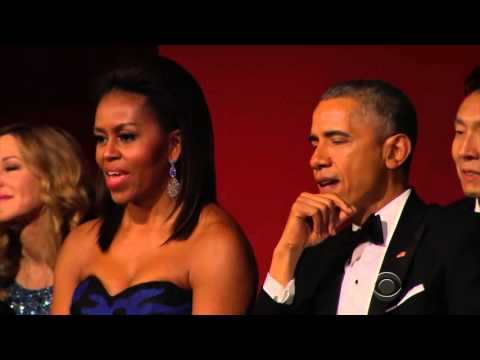

In [3]:
YouTubeVideo("8cF0tf35Mbo")